In [ ]:
pip install wget

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9657 sha256=71adb98fcada03f2cd71a3a8df274015a76305b63431ea527e822324e7cc6675
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget


In [28]:
import re
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import os
import cv2
import glob
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler
import shutil
from decimal import Decimal, getcontext
import wget
import requests
from urllib.request import urlopen as uReq
from google.colab.patches import cv2_imshow
import datetime
import altair as alt

In [ ]:
mdata = pd.read_csv('sample_data/Milkweed_iNaturalist.csv', sep=',', encoding='latin-1')
mdata.head()

,id,observed_on_string,observed_on,time_observed_at,time_zone,user_id,user_login,user_name,created_at,updated_at,...,geoprivacy,taxon_geoprivacy,coordinates_obscured,positioning_method,positioning_device,species_guess,scientific_name,common_name,iconic_taxon_name,taxon_id
0,101943,Sun Jul 15 2012 14:33:04 GMT-0500 (CDT),7/15/2012,2012-07-15 19:33:04 UTC,Central Time (US & Canada),6113,montanamike,NaN,2012-07-16 01:41:15 UTC,2017-05-13 02:16:27 UTC,...,NaN,NaN,False,NaN,NaN,common milkweed,Asclepias syriaca,common milkweed,Plantae,47911
1,160843,12/11/2012,12/11/2012,NaN,Central Time (US & Canada),8882,bouteloua,cassi saari,2012-12-12 02:52:15 UTC,2018-03-11 20:16:29 UTC,...,NaN,NaN,False,NaN,NaN,common milkweed,Asclepias syriaca,common milkweed,Plantae,47911
2,311680,"June 25, 2013 10:49:00 AM CDT",6/25/2013,2013-06-25 15:49:00 UTC,Central Time (US & Canada),18260,mergirl22,NaN,2013-06-25 19:54:12 UTC,2017-05-13 02:26:32 UTC,...,NaN,NaN,False,gps,gps,common milkweed,Asclepias syriaca,common milkweed,Plantae,47911
3,375506,Wed Aug 21 2013 10:31:33 GMT-0500 (CDT),8/21/2013,2013-08-21 15:31:33 UTC,Central Time (US & Canada),19192,eplonka1,NaN,2013-08-24 15:22:46 UTC,2017-05-13 03:31:51 UTC,...,NaN,NaN,False,NaN,NaN,common milkweed,Asclepias syriaca,common milkweed,Plantae,47911
4,393770,9/5/2013 14:32,9/5/2013,2013-09-05 21:32:03 UTC,Pacific Time (US & Canada),2991,sea-kangaroo,NaN,2013-09-10 21:12:19 UTC,2023-03-05 17:34:49 UTC,...,NaN,NaN,False,NaN,manual,Broadleaf Milkweed,Asclepias syriaca,common milkweed,Plantae,47911


In [ ]:
for val in range(len(mdata)):
  try:
    url = mdata.image_url[val]
    wget.download(url, out='sample_data/img/')
    old_name = 'sample_data/img/'+ url[url.rindex('/')+1:]
    new_name = 'sample_data/img/'+ url[url.rindex('/')+1: url.rindex('.')] + str(val) + url[url.rindex('.'):]
    os.rename(old_name, new_name)
  except:
    print(val)

In [ ]:
from google.colab import files
files.download('/content/sample_data/img')

In [21]:
mdata.observed_on



0        7/15/2012
1       12/11/2012
2        6/25/2013
3        8/21/2013
4         9/5/2013
           ...    
4205     3/20/2023
4206     3/20/2023
4207     3/21/2023
4208     3/21/2023
4209     7/10/2022
Name: observed_on, Length: 4210, dtype: object

In [23]:
months = pd.to_datetime(mdata['observed_on'], format='%m/%d/%Y').dt.month 

In [25]:
mdata['month'] = months

In [27]:
mdata['month'].value_counts()


6     1023
7      971
9      671
8      640
10     254
5      207
11     103
4      101
3       81
1       67
12      53
2       39
Name: month, dtype: int64

In [70]:
h1 = 50
h2 = 150
h1w = 49
h2w = 60
s1w = 5
s2w = 50
v = 150
S = 100
T = 30
t = T/255


In [73]:
def scorer(hsvImg):

  imgHue = hsvImg[:,:,0]
  imgSat = hsvImg[:,:,1]
  imgVal = hsvImg[:,:,2]
  [row,col] = imgHue.shape

  gscore = 0
  brscore = 0
  total = row*col;

  H1Img = np.zeros([row, col])
  for r in range(row):
    for c in range(col):
      hval = imgHue[r,c]
      if (hval > h1 and hval < h2):
        H1Img[r,c] = hval
      else:
        H1Img[r,c] = 0
        brscore +=1

  H2Img = np.zeros([row, col])

  for r in range(row):
    for c in range(col):
      hval = H1Img[r,c]
      if hval != 0:
        if (49>hval or hval>60 or 5>imgSat[r,c] or imgSat[r,c] > 50 or imgVal[r,c] < 150):
          H2Img[r,c] = hval
          gscore +=1
    return [gscore, brscore, total]



In [74]:
percgreen = []
percbrown = []
total = []
for imgname in os.listdir('sample_data/img'):
  img = cv2.imread('sample_data/img/' + imgname)
  hsvImg = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
  [green, brown, tot] = scorer(hsvImg)
  if green != 0:
    greenp = green*100/tot
  else:
    greenp = 0

  if brown != 0:
    brownp = brown*100/tot
  else:
    brownp = 0


  percgreen.append(greenp)
  percbrown.append(brownp)
  total.append(tot)


In [75]:
mdata['percentgreen'] = percgreen
mdata['month'] = percbrown
mdata['month'] = total

In [76]:
mdata.percentgreen

0       0.091733
1       0.127572
2       0.000000
3       0.080214
4       0.000000
          ...   
4205    0.000533
4206    0.000533
4207    0.179580
4208    0.018133
4209    0.040240
Name: percentgreen, Length: 4210, dtype: float64

In [17]:
img = cv2.imread('sample_data/img/medium0.jpg')
gray = cv2.imread('sample_data/img/medium0.jpg', cv2.IMREAD_GRAYSCALE)
#hsvImg = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)



In [11]:
rbgimg = []


In [12]:
for imgname in os.listdir('sample_data/milktrain'):
  img = cv2.imread('sample_data/milktrain/' + imgname)
  #hsvImg = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
  [row,col, channels] = img.shape

  for ro in range(row):
    for co in range(col):
      [bl,gr,re] = img[ro,co]
      #print(str(bl) + ', '  + str(gr) + ', ' + str(re))

      if (bl != 0 and gr != 0 and re != 0):

       # b.append(bl)
       # g.append(gr)
        #r.append(re)
        rbgimg.append([bl, gr, re])

       # heu,sat,va = hsvImg[ro,co]
        #h.append(heu)
        #s.append(sat)
        #v.append(va)



In [13]:
img = cv2.imread('sample_data/img/medium0.jpg')
gray = cv2.imread('sample_data/img/medium0.jpg', cv2.IMREAD_GRAYSCALE)
#hsvImg = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

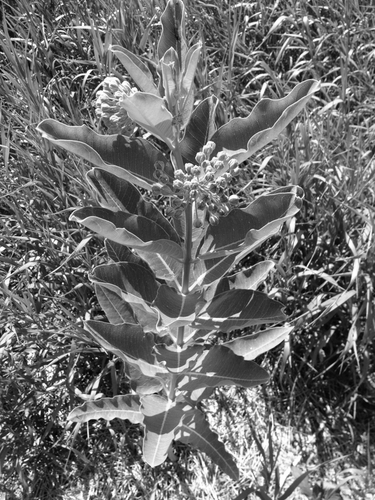

In [14]:
cv2_imshow(gray)

In [15]:
[row,col] = gray.shape
for rw in range(row):
  for cl in range(col):
     bl,gr,re = img[rw,cl]
     blgre = [bl, gr, re]
     if blgre not in rbgimg:
      gray[rw,cl] = 0



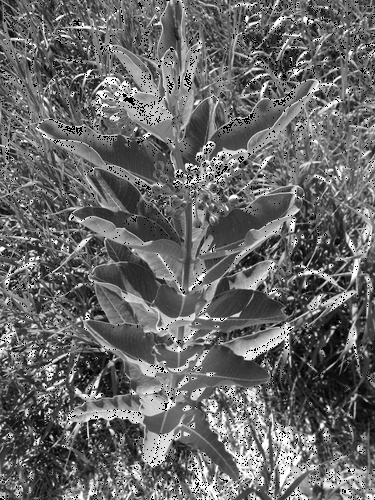

In [16]:
cv2_imshow(gray)

In [ ]:
for imgname in os.listdir('img'):
  img = cv2.imread('img/' + imgname)
  